# 3.3 Prob Distributions

**Base Teacher**

In [62]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import math

class TeacherModel(nn.Module):
    def __init__(self):
        super().__init__()
        model = models.vgg16(pretrained=True)
        self.features = model.features
        self.pool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 100)
        )
        
        for param in model.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)  # Apply pooling here
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

**Base Student**

In [63]:
class StudentModel(nn.Module):
    def __init__(self):
        super().__init__()
        model = models.vgg11(pretrained=True)
        self.features = model.features
        
        # Update the input size of the first linear layer
        self.classifier = nn.Sequential(
            nn.Linear(25088, 2048),  # Change here
            nn.BatchNorm1d(2048),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(1024, 100)
        )
                
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)
            
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


**Crd Student**

In [64]:
class StudentModelCRD(nn.Module):
    def __init__(self):
        super().__init__()
        
        vgg11 = models.vgg11(pretrained=True)
        self.features = vgg11.features  
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 100)  
        )
        
        self.projection = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(True)
        )
        
        self.apply(self._init_weights)  
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        x = self.features(x)
        x = nn.AdaptiveAvgPool2d((7, 7))(x) 
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
    def get_features(self, x):
        x = self.features(x)
        x = nn.AdaptiveAvgPool2d((7, 7))(x)
        x = torch.flatten(x, 1)
        x = self.classifier[:-1](x) 
        x = self.projection(x)  
        return x

**Hint Student**

In [65]:
class HintStudentModel(nn.Module):
    def __init__(self):
        super().__init__()
        model = models.vgg11(pretrained=True)
        self.features = model.features
        
        dummy_input = torch.randn(1, 3, 224, 224)  
        dummy_output = self.features(dummy_input)
        flattened_size = dummy_output.view(dummy_output.size(0), -1).size(1) 

        self.regressor = nn.Conv2d(512, 512, kernel_size=1)

        self.classifier = nn.Sequential(
            nn.Linear(flattened_size, 2048), 
            nn.BatchNorm1d(2048),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(1024, 100)
        )
        
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)
            
    def forward(self, x):
        features = self.features(x)
        hint_features = self.regressor(features)  # Match teacher's feature dimensions
        
        # Flatten features for classifier
        x = torch.flatten(features, 1)
        logits = self.classifier(x)
        
        return logits, hint_features


In [66]:

def load_data(batch_size=128):
    """Load CIFAR-100 dataset."""
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Resize(224),
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(224),
    ])
    
    trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return trainloader, testloader

In [67]:
import torch
import torch.nn.functional as F
import random

def select_query_images(test_loader, num_images):
    """Select a subset of images and labels from the test loader."""
    images = []
    labels = []
    
    sampled_indices = random.sample(range(len(test_loader.dataset)), num_images)
    
    for idx in sampled_indices:
        img, lbl = test_loader.dataset[idx]
        images.append(img)
        labels.append(lbl)
    
    images = torch.stack(images)
    labels = torch.tensor(labels)
    
    return images, labels


In [68]:

def get_probabilities(model, dataloader, device):
    model.eval()
    probabilities = []
    
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            
            softmax_outputs = F.softmax(outputs, dim=1)
            probabilities.append(softmax_outputs.cpu())
    
    return torch.cat(probabilities)


In [69]:

trainloader, testloader = load_data()
num_query_images = 100
query_images, query_labels = select_query_images(testloader, num_query_images)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

teacher_model = TeacherModel().to(device)
independent_student_model = StudentModel().to(device)
student_model_logit_matching = StudentModel().to(device)
student_model_crd = StudentModelCRD().to(device)
student_model_hint = HintStudentModel().to(device)

teacher_model.load_state_dict(torch.load('/kaggle/input/baseteacher/pytorch/default/1/best_teacher.pth'))
independent_student_model.load_state_dict(torch.load('/kaggle/input/basicstudent/pytorch/default/1/trained_student_model_5_epochs.pth'))
student_model_logit_matching.load_state_dict(torch.load('/kaggle/input/logitmatchingstudent/pytorch/default/1/student_with_logit_matching.pth'))
student_model_crd.load_state_dict(torch.load('/kaggle/input/crdstudent/pytorch/default/1/CRDfinal_student_model.pth'))
student_model_hint.load_state_dict(torch.load('/kaggle/input/studenthint/pytorch/default/1/best_student_hint.pth'))

teacher_model.eval()
independent_student_model.eval()
student_model_logit_matching.eval()
student_model_crd.eval()
student_model_hint.eval()

teacher_probs = get_probabilities(teacher_model, testloader, device)
student_probs_independent = get_probabilities(independent_student_model, testloader, device)
student_probs_logit_matching = get_probabilities(student_model_logit_matching, testloader, device)
student_probs_crd = get_probabilities(student_model_crd, testloader, device)
student_probs_hint = get_probabilities(student_model_hint, testloader, device)


Files already downloaded and verified
Files already downloaded and verified


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warni

In [83]:
def compute_kl_divergence(p, q):
    """Calculate KL divergence between distributions p (teacher) and q (student)."""
    kl_div = F.kl_div(F.log_softmax(q, dim=1), F.softmax(p, dim=1), reduction='batchmean')
    return kl_div.item()

kl_logit_matching = compute_kl_divergence(teacher_probs, student_probs_logit_matching)
kl_hint = compute_kl_divergence(teacher_probs, student_probs_hint)
kl_crd = compute_kl_divergence(teacher_probs, student_probs_crd)
kl_independent = compute_kl_divergence(teacher_probs, student_probs_independent)

Logit Matching: 0.0022360661532729864
Hint: 0.0020318860188126564
CRD: 0.0014210714725777507
Independent: 0.002383313374593854


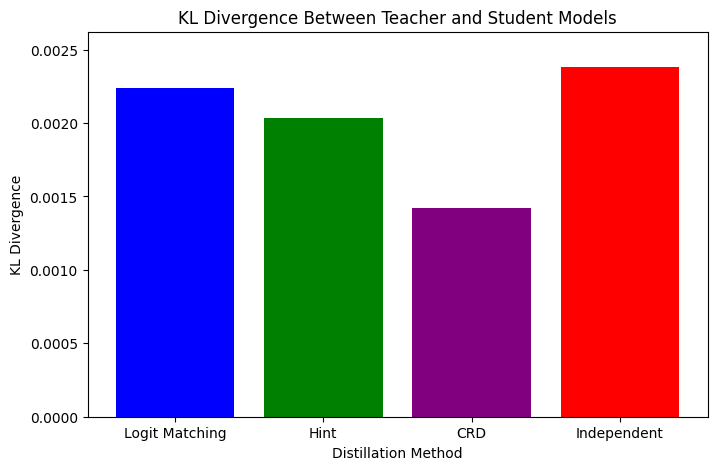

In [84]:
import matplotlib.pyplot as plt

kl_values = {
    'Logit Matching': kl_logit_matching,
    'Hint': kl_hint,
    'CRD': kl_crd,
    'Independent': kl_independent
}

def plot_kl_divergence(kl_values):
    """Plots KL divergence values for each model comparison and prints the values."""
    
    model_names = list(kl_values.keys())
    kl_scores = list(kl_values.values())
    
    for method, score in zip(model_names, kl_scores):
        print(f"{method}: {score}")
    
    plt.figure(figsize=(8, 5))
    plt.bar(model_names, kl_scores, color=['blue', 'green', 'purple', 'red'])
    

    plt.xlabel('Distillation Method')
    plt.ylabel('KL Divergence')
    plt.title('KL Divergence Between Teacher and Student Models')
    plt.ylim(0, max(kl_scores) * 1.1)  
    
    plt.show()

plot_kl_divergence(kl_values)


In [85]:
import torch
import torch.nn.functional as F

def compute_js_divergence(p, q):
    """Calculate Jensen-Shannon divergence between distributions p (teacher) and q (student)."""
    m = 0.5 * (F.softmax(p, dim=1) + F.softmax(q, dim=1))
    
    kl_pm = F.kl_div(F.log_softmax(m, dim=1), F.softmax(p, dim=1), reduction='batchmean')
    kl_qm = F.kl_div(F.log_softmax(m, dim=1), F.softmax(q, dim=1), reduction='batchmean')
    
    js_div = 0.5 * (kl_pm + kl_qm)
    return js_div.item()

js_logit_matching = compute_js_divergence(teacher_probs, student_probs_logit_matching)
js_hint = compute_js_divergence(teacher_probs, student_probs_hint)
js_crd = compute_js_divergence(teacher_probs, student_probs_crd)
js_independent = compute_js_divergence(teacher_probs, student_probs_independent)


Logit Matching: 0.0012928294017910957
Hint: 0.0012219642521813512
CRD: 0.002611355623230338
Independent: 0.0016028510872274637


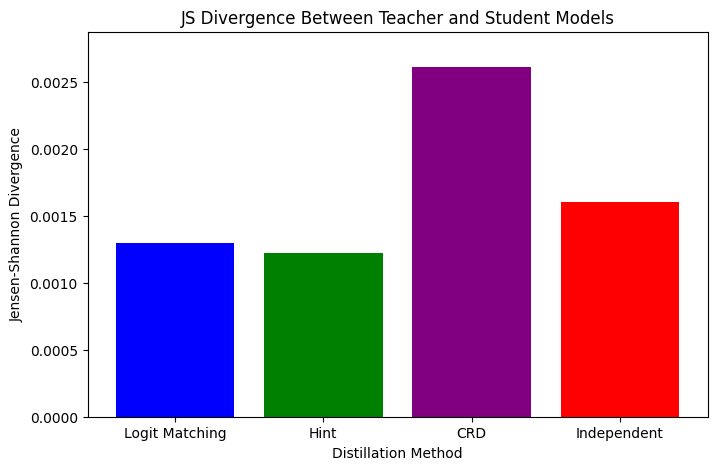

In [86]:
import matplotlib.pyplot as plt

js_values = {
    'Logit Matching': js_logit_matching,
    'Hint': js_hint,
    'CRD': js_crd,
    'Independent': js_independent
}

def plot_js_divergence(js_values):
    """Plots JS divergence values for each model comparison and prints the values."""
    
    model_names = list(js_values.keys())
    js_scores = list(js_values.values())
    
    for method, score in zip(model_names, js_scores):
        print(f"{method}: {score}")
    
    plt.figure(figsize=(8, 5))
    plt.bar(model_names, js_scores, color=['blue', 'green', 'purple', 'red'])
    
    plt.xlabel('Distillation Method')
    plt.ylabel('Jensen-Shannon Divergence')
    plt.title('JS Divergence Between Teacher and Student Models')
    plt.ylim(0, max(js_scores) * 1.1) 
    
    plt.show()

plot_js_divergence(js_values)


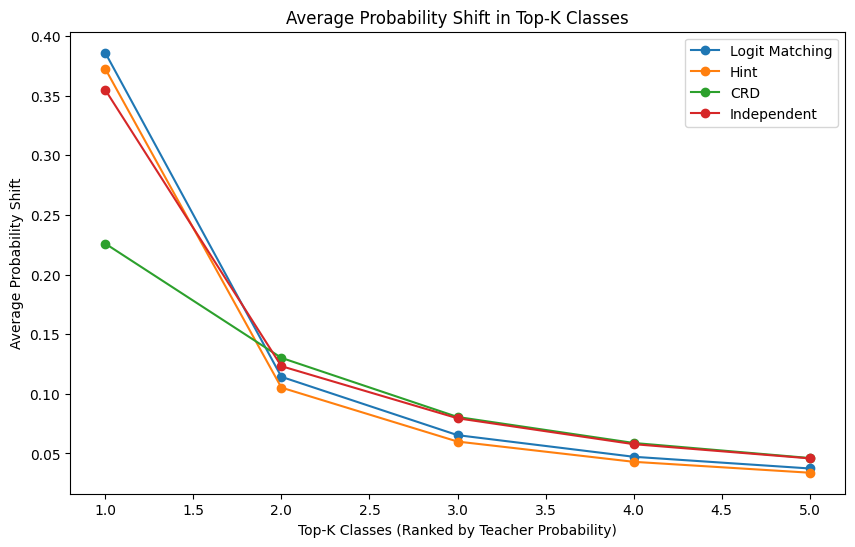

In [87]:
import numpy as np
import matplotlib.pyplot as plt

def average_probability_shift_plot(teacher_probs, student_probs_dict, top_k=5):
    """Plots the average probability shift for the top-K classes between teacher and student models."""
    num_images, num_classes = teacher_probs.shape
    
    top_k_indices = np.argsort(-teacher_probs, axis=1)[:, :top_k] 
    avg_shifts = {model_name: [] for model_name in student_probs_dict.keys()}
    
    for model_name, student_probs in student_probs_dict.items():
        shifts = []
        for i in range(num_images):
            teacher_top_probs = teacher_probs[i, top_k_indices[i]]
            student_top_probs = student_probs[i, top_k_indices[i]]
            shift = np.abs(teacher_top_probs - student_top_probs)
            shifts.append(shift)
        avg_shifts[model_name] = np.mean(shifts, axis=0)
    
    plt.figure(figsize=(10, 6))
    for model_name, shift in avg_shifts.items():
        plt.plot(range(1, top_k + 1), shift, marker='o', label=model_name)
    
    plt.xlabel('Top-K Classes (Ranked by Teacher Probability)')
    plt.ylabel('Average Probability Shift')
    plt.title('Average Probability Shift in Top-K Classes')
    plt.legend()
    plt.show()

student_probs_dict = {
    'Logit Matching': student_probs_logit_matching,
    'Hint': student_probs_hint,
    'CRD': student_probs_crd,
    'Independent': student_probs_independent
}
average_probability_shift_plot(teacher_probs, student_probs_dict, top_k=5)


# 3.4

In [101]:
class GradTeacherModel(nn.Module):
    def __init__(self, model):
        super(GradTeacherModel, self).__init__()
        self.model = model
        
        self.features_conv = self.model.features[:29]
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.classifier = self.model.classifier
        
        for param in self.model.parameters():
            param.requires_grad = True
        
        self.gradients = None
        
    def activations_hook(self, grad):
        self.gradients = grad
    
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the gradient
        h = x.register_hook(self.activations_hook)
        
        x = self.max_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)
    
    
class GradStudentModel(nn.Module):
    def __init__(self, model):
        super(GradStudentModel, self).__init__()
        self.model = model
        # dissecting to the last convolutional layer
        self.features_conv = self.model.features[:19]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier
        self.classifier = self.model.classifier
        
        self.gradients = None
        
    def activations_hook(self, grad):
        self.gradients = grad
    
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the gradient
        h = x.register_hook(self.activations_hook)
        
        x = self.max_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)
  

In [103]:
# loading grad cam for teacher and student models
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)
train_loader, test_loader = load_data()

grad_teacher = GradTeacherModel(teacher_model)
grad_student = GradStudentModel(independent_student_model)
grad_logit_matching = GradStudentModel(student_model_logit_matching)
grad_hints = GradStudentModel(student_model_hint)
grad_crd = GradStudentModel(student_model_crd)

Files already downloaded and verified
Files already downloaded and verified


In [104]:
# get predictions of the model
grad_teacher.to(device).eval()
grad_student.to(device).eval()
grad_logit_matching.to(device).eval()
grad_hints.to(device).eval()
grad_crd.to(device).eval()

img, _ = next(iter(test_loader))
img = img[2].to(device).unsqueeze(dim=0)

pred_teacher = grad_teacher(img)
teach_class = pred_teacher.argmax(dim=1)

pred_student = grad_student(img)
student_class = pred_student.argmax(dim=1)

pred_lm = grad_logit_matching(img)
lm_class = pred_lm.argmax(dim=1)

pred_hints = grad_hints(img)
hints_class = pred_hints.argmax(dim=1)

pred_crd = grad_crd(img)
crd_class = pred_crd.argmax(dim=1)

In [105]:
grad_teacher.to(device).eval()
grad_student.to(device).eval()
grad_logit_matching.to(device).eval()
grad_hints.to(device).eval()
grad_crd.to(device).eval()

img, _ = next(iter(test_loader))
img = img[2].to(device).unsqueeze(dim=0)  

pred_teacher = grad_teacher(img)
teach_class = pred_teacher.argmax(dim=1) 
print(f"Teacher model predicted label: {teach_class.item()}")

pred_student = grad_student(img)
student_class = pred_student.argmax(dim=1)  
print(f"Student model predicted label: {student_class.item()}")

pred_lm = grad_logit_matching(img)
lm_class = pred_lm.argmax(dim=1)  
print(f"Logit Matching model predicted label: {lm_class.item()}")

pred_hints = grad_hints(img)
hints_class = pred_hints.argmax(dim=1) 
print(f"Hint model predicted label: {hints_class.item()}")

pred_crd = grad_crd(img)
crd_class = pred_crd.argmax(dim=1)  
print(f"CRD model predicted label: {crd_class.item()}")


Teacher model predicted label: 23
Student model predicted label: 60
Logit Matching model predicted label: 60
Hint model predicted label: 67
CRD model predicted label: 71


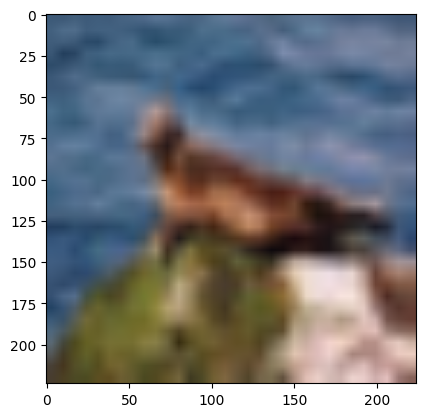

In [106]:
plt.imshow(img.cpu().view(3, 224, 224).permute(1,2,0))

In [107]:
# get the gradients of the output with respect to the parameters of the model.
pred_teacher[:, 23].backward()
pred_student[:, 60].backward()
pred_lm[:, 60].backward()
pred_hints[:, 67].backward()
pred_crd[:, 71].backward()

In [108]:
# pull the gradients out of the model.
gradients_t = grad_teacher.get_activations_gradient()
gradients_s = grad_student.get_activations_gradient()
gradients_lm = grad_logit_matching.get_activations_gradient()
gradients_h = grad_hints.get_activations_gradient()
gradients_c = grad_crd.get_activations_gradient()

# pool the gradients across the channels.
pool_gt = torch.mean(gradients_t, dim=[0,2,3])
pool_gs = torch.mean(gradients_s, dim=[0,2,3])
pool_glm = torch.mean(gradients_lm, dim=[0,2,3])
pool_gh = torch.mean(gradients_h, dim=[0,2,3])
pool_gc = torch.mean(gradients_c, dim=[0,2,3])


# get the activations of the last convolutional layer
activations_t = grad_teacher.get_activations(img).detach()
activations_s = grad_student.get_activations(img).detach()
activations_lm = grad_logit_matching.get_activations(img).detach()
activations_h = grad_hints.get_activations(img).detach()
activations_c = grad_crd.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations_t[:, i, :, :] *=pool_gt[i]
    activations_s[:, i, :, :] *=pool_gs[i]
    activations_lm[:, i, :, :] *=pool_glm[i]
    activations_h[:, i, :, :] *=pool_gh[i]
    activations_c[:, i, :, :] *=pool_gc[i]

# averge the channels of the activations
heatmap_t = torch.mean(activations_t, dim=1).squeeze()
heatmap_s = torch.mean(activations_s, dim=1).squeeze()
heatmap_lm = torch.mean(activations_lm, dim=1).squeeze()
heatmap_h = torch.mean(activations_h, dim=1).squeeze()
heatmap_c = torch.mean(activations_c, dim=1).squeeze()

# relu activation
heatmap_t = torch.nn.functional.relu(heatmap_t)
heatmap_s = torch.nn.functional.relu(heatmap_s)
heatmap_lm = torch.nn.functional.relu(heatmap_lm)
heatmap_h = torch.nn.functional.relu(heatmap_h)
heatmap_c = torch.nn.functional.relu(heatmap_c)

# normalize the heatmap
heatmap_t /=torch.max(heatmap_t)
heatmap_s /=torch.max(heatmap_s)
heatmap_lm /=torch.max(heatmap_lm)
heatmap_h /=torch.max(heatmap_h)
heatmap_c /=torch.max(heatmap_c)

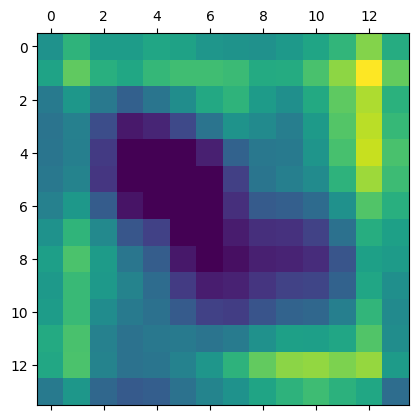

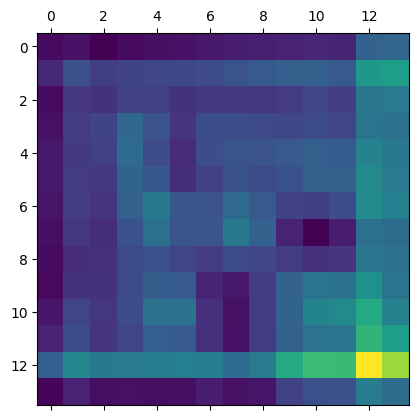

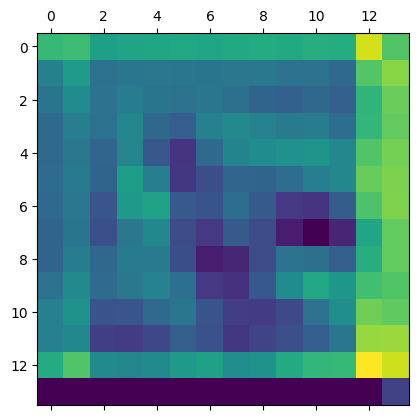

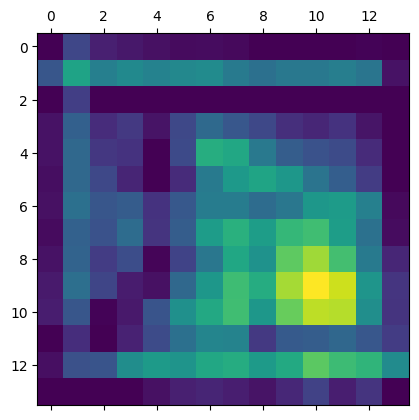

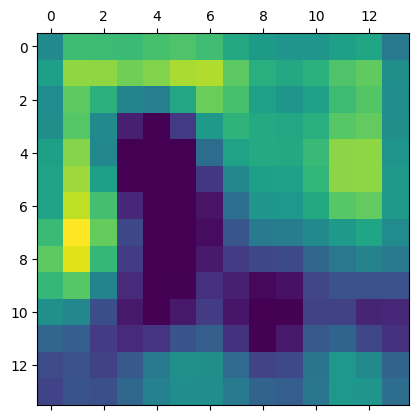

In [109]:
plt.matshow(heatmap_t.cpu().numpy().squeeze())
plt.matshow(heatmap_s.cpu().numpy().squeeze())
plt.matshow(heatmap_lm.cpu().numpy().squeeze())
plt.matshow(heatmap_h.cpu().numpy().squeeze())
plt.matshow(heatmap_c.cpu().numpy().squeeze())

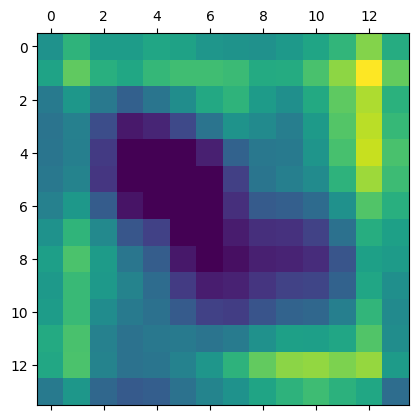

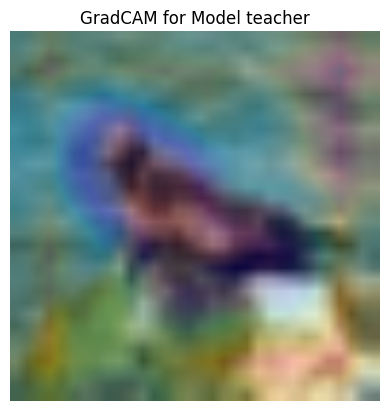

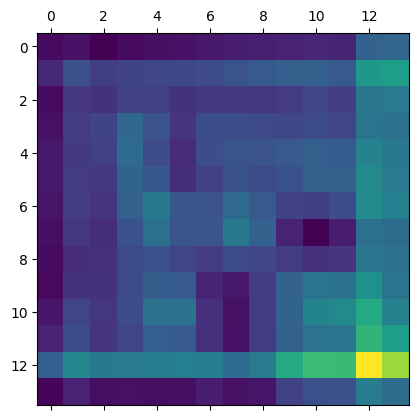

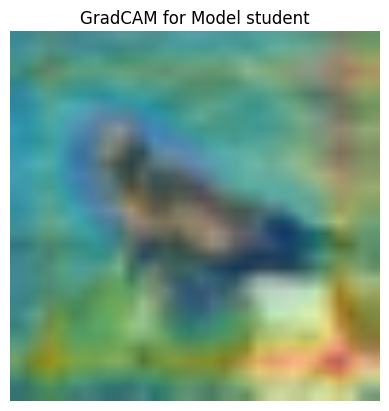

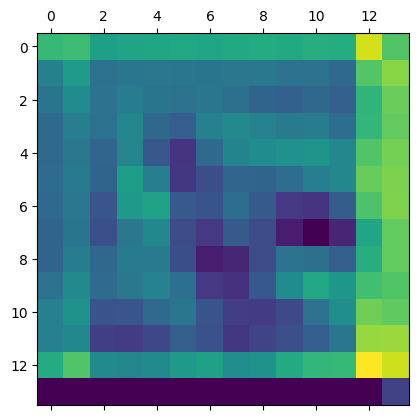

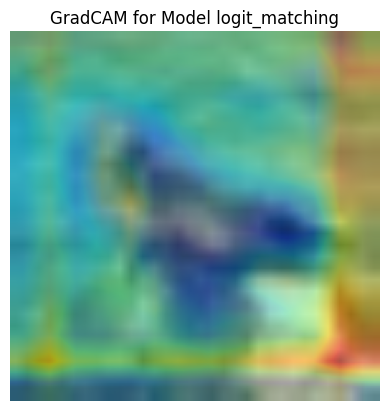

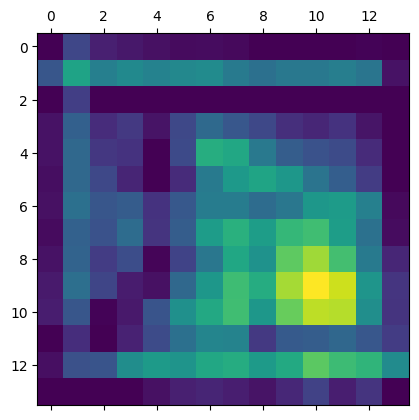

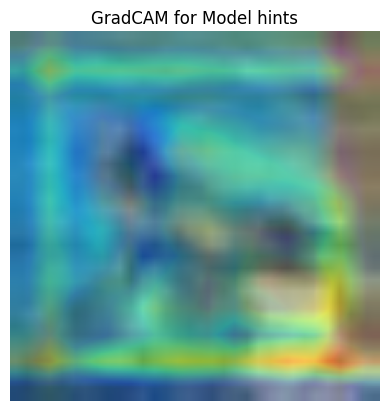

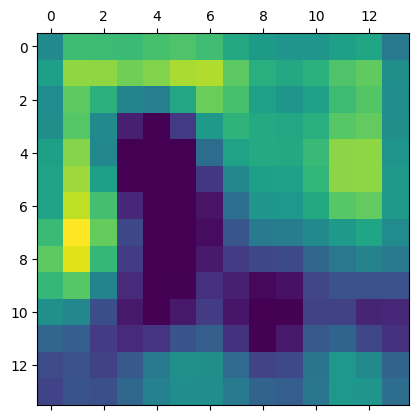

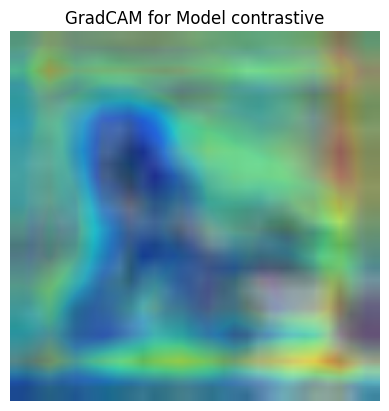

In [110]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Function to create a color map
def apply_colormap(heatmap):
    heatmap = (heatmap * 255).byte() 

    colormap = plt.get_cmap('jet')
    heatmap_color = colormap(heatmap.cpu().numpy(), bytes=True) 
    return torch.tensor(heatmap_color[:, :, :3]).permute(2, 0, 1) / 255 

def resize_heatmap(heatmap, target_size):
    return torch.nn.functional.interpolate(
        heatmap.unsqueeze(0).unsqueeze(0),  
        size=target_size,  
        mode='bilinear',
        align_corners=False
    ).squeeze(0).squeeze(0)  

def blend_heatmap_on_image(img, heatmap, alpha=0.2):
    img_float = img.permute(1, 2, 0).float()  # Change from (C, H, W) to (H, W, C)

    heatmap_resized = resize_heatmap(heatmap, img.shape[1:])
    heatmap_color = apply_colormap(heatmap_resized)
    return img_float * (1 - alpha) + heatmap_color.permute(1, 2, 0) * alpha

def overlay_heatmaps_on_image(img, *heatmaps):
    models = ["Teacher", "Student", "Logit Matching", "Hint-based KD", "Contrastive KD"]
    
    for i, heatmap in enumerate(heatmaps):
        superimposed_img = blend_heatmap_on_image(img, heatmap)

        plt.title(f"GradCAM for {models[i]}")
        plt.imshow(superimposed_img.numpy())
        plt.axis('off')
        plt.show()

img1 = img.squeeze().cpu() 
overlay_heatmaps_on_image(img1, heatmap_t, heatmap_s, heatmap_lm, heatmap_h, heatmap_c)
